# Партнерская задача: тематическая классификация текстов

In [51]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import inflect
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from scipy.sparse import hstack
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.sparse import hstack
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avmar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\avmar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [53]:
import sys
print(sys.executable)

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Scripts\python.exe


## 1. Исследование датасета и предобработка данных

даны 6 датасетов (каждый датасет - отдельный класс) + описание

разделение "текст поста", video2text [OCR], speech2text [ASR]

In [54]:
df1 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/1.csv')
df2 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/2.csv')
df3 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/3.csv')
df4 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/4.csv')
df5 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/5.csv')
df6 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/6.csv')

In [55]:
df1['class'] = 1
df2['class'] = 2
df3['class'] = 3
df4['class'] = 4
df5['class'] = 5
df6['class'] = 6

In [56]:
df_gen = pd.concat([df1, df2, df3, df4, df5, df6]).reset_index()

Функция для преобразования эмоджи в их текстовые описания (перечисляет их через запятую)

In [57]:
def extract_emojis(text):
    if not isinstance(text, str):
        return np.nan

    # Находим все эмодзи в тексте
    emoji_chars = [c for c in text if c in emoji.EMOJI_DATA]

    if not emoji_chars:
        return np.nan

    # Преобразуем эмодзи в текстовые описания (без : и _)
    emoji_descriptions = [
        emoji.demojize(e, delimiters=(" ", " "))
        .replace(":", "").replace("_", " ")
        .strip()
        for e in emoji_chars
    ]

    # Объединяем через запятую
    return ", ".join(emoji_descriptions)

Функция для удаления эмоджи из текта

In [58]:
def remove_emojis(text):
    if not isinstance(text, str):
        return np.nan
    return emoji.replace_emoji(text, replace="")

Функция для предварительной очистки и нормализации текста

In [59]:
def base_clean_text(text: str):
    if not isinstance(text, str):
        return np.nan

    text = text.lower()

    # Удаляем URL, хэштеги, упоминания ДО split()
    text = re.sub(r'(https?://\S+)|(#\w+)|(@\w+)', '', text)

    # Удаляем скобки/кавычки, мешающие обработке
    text = re.sub(r'[()\[\]{}"\']', '', text)

    # Оставляем только буквы и пробелы
    text = re.sub(r'[^\sа-яёa-z]', '', text)

    # Убираем повторы букв (например, "привееет" -> "привет")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    stop_words = set(stopwords.words('russian'))
    temp = inflect.engine()
    words = []

    for word in text.split():
        if word.isdigit():
            words.append(temp.number_to_words(word))
        elif word and word not in stop_words:  # игнорируем пустые строки и стоп-слова
            words.append(word)

    return ' '.join(words) if words else np.nan

Функция для приведения слов к их корневой форме

In [60]:
def stem_russian_text(text):
    stemmer = RussianStemmer()
    words = text.split()
    stemmed_words = []
    for word in words:
        if re.match('[а-яА-Я]', word):
            stemmed_word = stemmer.stem(word)
            stemmed_words.append(stemmed_word)
        else:
            stemmed_words.append(word)
    return ' '.join(stemmed_words)

Применяем функции на агреггированном датасете

In [61]:
df_gen['emojis_doc_text'] = df_gen['doc_text'].apply(extract_emojis)

In [62]:
df_gen['emojis_doc_text'] = df_gen['emojis_doc_text'].fillna('').values

In [63]:
df_gen['doc_text'] = df_gen['doc_text'].apply(remove_emojis)

In [64]:
for col in ['doc_text', 'image2text', 'speech2text']:
    df_gen[f'cleaned_{col}'] = [base_clean_text(x) if isinstance(x, str) else np.nan
                                 for x in df_gen[col]]

In [65]:
for col in ['doc_text', 'image2text', 'speech2text']:
    df_gen[f'stemmed_{col}'] = [stem_russian_text(x) if isinstance(x, str) else np.nan
                                 for x in df_gen[f'cleaned_{col}']]

In [66]:
def clean_text_for_spacy(text: str):
    if not isinstance(text, str):
        return np.nan
    
    # Удаляем URL, хэштеги, упоминания (но сохраняем пунктуацию!)
    text = re.sub(r'(https?://\S+)|(#\w+)|(@\w+)', '', text)
    
    # Удаляем только проблемные символы (например, математические)
    text = re.sub(r'[{}<>$%^&*|\\]', '', text)
    
    # Приводим к нижнему регистру (spaCy сам обрабатывает регистр)
    text = text.lower()
    
    # Убираем повторы букв (но сохраняем пунктуацию)
    text = re.sub(r'([а-яёa-z])\1{2,}', r'\1', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if text else np.nan

In [67]:
for col in ['doc_text', 'image2text', 'speech2text']:
    df_gen[f'SpaCy_{col}'] = [clean_text_for_spacy(x) if isinstance(x, str) else np.nan
                                 for x in df_gen[col]]

In [68]:
def analyze_text_column(column):
    all_words = ' '.join(column.fillna('')).split()
    word_freq = Counter(all_words)
    print(f"Top 20 слов для {column.name}:")
    print(word_freq.most_common(20))

In [69]:
# Длина текстов
df_gen['doc_length'] = df_gen['stemmed_doc_text'].str.split().str.len()
df_gen['image_length'] = df_gen['stemmed_image2text'].str.split().str.len()

## 2. Feature Engineering

In [70]:
for col in df_gen[['doc_text', 'image2text', 'speech2text', 'emojis_doc_text', 'cleaned_doc_text', 'cleaned_image2text', 'cleaned_speech2text', 'stemmed_doc_text', 'stemmed_image2text', 'stemmed_speech2text', 'SpaCy_doc_text', 'SpaCy_image2text', 'SpaCy_speech2text']]:
    df_gen[col] = df_gen[col].fillna('').values

In [71]:
tfidf = TfidfVectorizer(
    max_features=5000,       # Ограничиваем количество фич
    min_df=5,                # Игнорировать слова, встречающиеся <5 раз
    max_df=0.7,              # Игнорировать слова, встречающиеся >70% документов
    ngram_range=(1, 2)       # Учитывать словосочетания (1-2 слова)
)

tfidf_low_quality = TfidfVectorizer(
    max_features=1000,
    min_df=10,  # Более строгий фильтр для редких слов
    max_df=0.9,
    token_pattern=r'\b[а-яё]{4,}\b'  # Только слова из 4+ русских букв
)

In [72]:
tfidf_doc = tfidf.fit_transform(df_gen['stemmed_doc_text'].fillna(''))
tfidf_image = tfidf_low_quality.fit_transform(df_gen['stemmed_image2text'].fillna(''))
tfidf_speech = tfidf_low_quality.fit_transform(df_gen['stemmed_speech2text'].fillna(''))

In [73]:
def custom_tokenizer(text):
    # Удаляем спецсимволы (но сохраняем слова с дефисами и апострофами)
    text = re.sub(r'[^\w\s-]', '', text.lower())
    
    # Токенизация с учетом русской морфологии
    tokens = word_tokenize(text, language='russian')
    
    # Фильтрация стоп-слов и коротких токенов
    russian_stopwords = set(stopwords.words('russian'))
    tokens = [token for token in tokens 
              if token not in russian_stopwords 
              and len(token) > 2 
              and not token.isdigit()]
    
    return tokens

In [74]:
tfidf_advanced = TfidfVectorizer(
    tokenizer=custom_tokenizer,          # Наш токенизатор
    analyzer='word',                     # Анализ по словам
    ngram_range=(1, 2),                  # Учитываем словосочетания
    min_df=3,                            # Игнорировать редкие слова (<3 документов)
    max_df=0.85,                         # Игнорировать слишком частые слова (>85% документов)
    sublinear_tf=True,                   # Логарифмическое масштабирование TF
    smooth_idf=True,                     # Сглаживание IDF
    norm='l2',                           # Нормализация векторов
    lowercase=True                       # Приводить к нижнему регистру (уже делаем в токенизаторе)
)

In [75]:
tfidf_doc_adv = tfidf_advanced.fit_transform(df_gen['SpaCy_doc_text'].fillna(''))

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 3.  Подбор признаков, их анализ и оценка важности

Попробуем улучшить результаты кластеризации, изменив характеристики токенизаторов

In [76]:
tfidf = TfidfVectorizer(
    max_features=5000,       # Ограничиваем количество фич
    min_df=10,                # Игнорировать слова, встречающиеся <5 раз
    max_df=0.6,              # Игнорировать слова, встречающиеся >70% документов
    ngram_range=(1, 3)       # Учитывать словосочетания (1-2 слова)
)

tfidf_low_quality = TfidfVectorizer(
    max_features=500,
    min_df=10,  # Более строгий фильтр для редких слов
    max_df=0.8,
    token_pattern=r'\b[а-яё]{4,}\b'  # Только слова из 4+ русских букв
)

tfidf_advanced = TfidfVectorizer(
    tokenizer=custom_tokenizer,          # Наш токенизатор
    analyzer='word',                     # Анализ по словам
    ngram_range=(1, 3),                  # Учитываем словосочетания
    min_df=6,                            # Игнорировать редкие слова (<3 документов)
    max_df=0.85,                         # Игнорировать слишком частые слова (>85% документов)
    sublinear_tf=True,                   # Логарифмическое масштабирование TF
    smooth_idf=True,                     # Сглаживание IDF
    norm='l2',                           # Нормализация векторов
    lowercase=True                       # Приводить к нижнему регистру (уже делаем в токенизаторе)
)

In [77]:
tfidf_doc = tfidf.fit_transform(df_gen['stemmed_doc_text'].fillna(''))
tfidf_image = tfidf_low_quality.fit_transform(df_gen['stemmed_image2text'].fillna(''))
tfidf_speech = tfidf_low_quality.fit_transform(df_gen['stemmed_speech2text'].fillna(''))
tfidf_doc_adv = tfidf_advanced.fit_transform(df_gen['SpaCy_doc_text'].fillna(''))

In [78]:
print("Форма TF-IDF матрицы:", tfidf_doc.shape)

Форма TF-IDF матрицы: (6000, 3953)


In [79]:
# Токенизация для SpaCy
nlp = spacy.load("ru_core_news_sm")
def spacy_tokenize(text):
    if isinstance(text, float) and np.isnan(text):  # Пропускаем NaN
        return []
    
    doc = nlp(text)
    return [
        token.text for token in doc
        if not token.is_space  # Игнорируем пробелы
    ]

In [80]:
df_gen['SpaCy_doct_text_tokens'] = df_gen['SpaCy_doc_text'].apply(spacy_tokenize)

## 4. Обучение нескольких моделей, их сравнение

In [81]:
X_combined = hstack([
    tfidf_doc * 0.3,
    tfidf_doc_adv * 0.6, # Делаем вес текста для SpaCy выше
    tfidf_image * 0.1,  # Понижаем вес OCR текста
    tfidf_speech * 0.05  # И ASR тоже
])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, 
    df_gen['class'], 
    test_size=0.2,
    stratify=df_gen['class']
)

In [83]:
CML_models_path = Path("../models")
CML_models_path.mkdir(parents=True, exist_ok=True)

In [84]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "RanFor": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced')
}

for name, model in models.items():
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказание и оценка
    y_pred = model.predict(X_test)
    print(f"\n{name}:\n", classification_report(y_test, y_pred))
    
    # Сохранение модели
    with open(CML_models_path / f"{name}.pkl", 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Модель {name} сохранена в {CML_models_path / f'{name}.pkl'}")


LogReg:
               precision    recall  f1-score   support

           1       0.69      0.67      0.68       200
           2       0.53      0.52      0.52       200
           3       0.76      0.82      0.79       200
           4       0.61      0.49      0.55       200
           5       0.65      0.70      0.68       200
           6       0.63      0.68      0.66       200

    accuracy                           0.65      1200
   macro avg       0.64      0.65      0.64      1200
weighted avg       0.64      0.65      0.64      1200

Модель LogReg сохранена в ..\models\LogReg.pkl

RanFor:
               precision    recall  f1-score   support

           1       0.62      0.61      0.62       200
           2       0.45      0.57      0.51       200
           3       0.79      0.74      0.76       200
           4       0.61      0.47      0.53       200
           5       0.61      0.67      0.64       200
           6       0.67      0.64      0.65       200

    accura

Статистики для классов 2 и 4 хуже всего

Модели LogReg и SVM лучше, но не достаточно хорошо, всего 64% accuracy

Построим матрицу, чтобы визуализировать, какие классы больше всего путает модель SVM

<Figure size 1000x800 with 0 Axes>

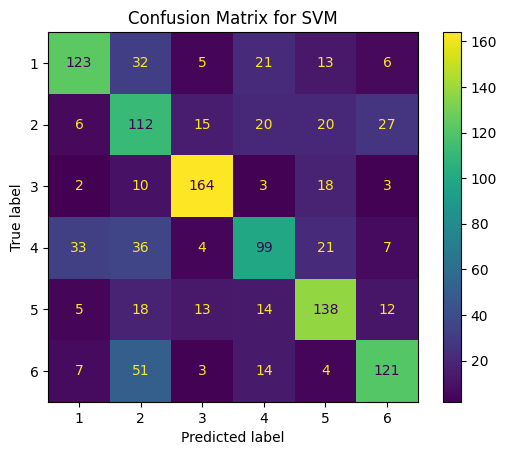

In [85]:
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(models["SVM"], X_test, y_test)
plt.title("Confusion Matrix for SVM")
plt.show()

Пробуем построить те же модели, предварительно создав метапризнаки

Создаем метапризнаки (и сразу их скейлируем для конкретной работы моделей)

In [86]:
meta_features = pd.DataFrame({
    'doc_length': df_gen['doc_text'].str.len(),          # Длина исходного текста
    'num_words': df_gen['stemmed_doc_text'].str.split().str.len(),  # Количество слов
    'num_emojis': df_gen['emojis_doc_text'].str.count(' ') + 1,    # Число эмодзи
    'has_image': df_gen['image2text'].notna().astype(int),          # Наличие картинки
    'has_speech': df_gen['speech2text'].notna().astype(int)         # Наличие аудио
})

Проверяем отсутствие пропусков

In [87]:
print(meta_features.isna().sum())

doc_length    0
num_words     0
num_emojis    0
has_image     0
has_speech    0
dtype: int64


In [88]:
scaler = StandardScaler()
meta_scaled = scaler.fit_transform(meta_features)

In [89]:
# Объединяем с текстовыми признаками
X_combined_meta = hstack([X_combined, meta_scaled])

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_meta, 
    df_gen['class'], 
    test_size=0.2,
    stratify=df_gen['class']
)

In [91]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "RanFor": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced')
}

for name, model in models.items():
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказание и оценка
    y_pred = model.predict(X_test)
    print(f"\n{name}:\n", classification_report(y_test, y_pred))
    
    # Сохранение модели
    with open(CML_models_path / f"{name}.pkl", 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Модель {name} сохранена в {CML_models_path / f'{name}.pkl'}")


LogReg:
               precision    recall  f1-score   support

           1       0.70      0.60      0.65       200
           2       0.47      0.46      0.46       200
           3       0.81      0.73      0.77       200
           4       0.55      0.41      0.47       200
           5       0.65      0.65      0.65       200
           6       0.53      0.81      0.64       200

    accuracy                           0.61      1200
   macro avg       0.62      0.61      0.61      1200
weighted avg       0.62      0.61      0.61      1200

Модель LogReg сохранена в ..\models\LogReg.pkl

RanFor:
               precision    recall  f1-score   support

           1       0.66      0.66      0.66       200
           2       0.39      0.56      0.46       200
           3       0.75      0.74      0.75       200
           4       0.55      0.41      0.47       200
           5       0.58      0.58      0.58       200
           6       0.68      0.58      0.63       200

    accura

После добавления мета признаков качество моделей либо почти не изменилось (для Log Reg accuracy стала 0.62), либо сильно ухудшилось (для SVM стало 0.53)

Вернемся на этап с токенизацией и попробуем BERT